# Show point clouds

# table of content
1) [Showing las pointcloud](#showing-las-pointclouds)
2) [Different file format generation](#different-file-format-generation)
3) [Convert all files of a folder](#convert-all-files-of-folder)
4) [Semantic splitting](#semantic-splitting)
5) [Instance splitting](#instances-splitting)

### Dependencies and general utils

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
import pdal
import json
from tqdm import tqdm

### Showing las pointclouds

#### Utils

In [9]:
def load_laz(file_path):
    las = laspy.read(file_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()  # Extract XYZ coordinates
    return points

def print_camera_info(vis):
    ctr = vis.get_view_control()

    saved_cam_params = ctr.convert_to_pinhole_camera_parameters()

    # Extract parameters
    intrinsic = saved_cam_params.intrinsic.intrinsic_matrix
    extrinsic = saved_cam_params.extrinsic
    fov = ctr.get_field_of_view()

    print("\nCamera Parameters:")
    print(f"Intrinsic Matrix:\n{intrinsic}")
    print(f"Extrinsic Matrix:\n{extrinsic}")
    print(f"Field of View: {fov} degrees\n")
    return False  # Do not block the visualization loop


def apply_camera_params(vis, extrinsic):
    ctr = vis.get_view_control()

    # Convert to Open3D format
    cam_params = ctr.convert_to_pinhole_camera_parameters()
    # cam_params.intrinsic.set_intrinsics(1280, 720, intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2])
    cam_params.extrinsic = np.array(extrinsic)

    # Apply settings
    ctr.convert_from_pinhole_camera_parameters(cam_params, allow_arbitrary=True)

    return False

def set_orthographic_view(vis, zoom=0.5, front=[0, 0, -1], lookat=[0, 0, 0], up=[0, -1, 0]):
    ctr = vis.get_view_control()
    ctr.set_lookat(lookat)
    ctr.set_front(front)
    ctr.set_up(up)
    ctr.set_zoom(zoom)

def visualize_laz(file_path, mode='normal', display_mode='3d', extrinsic=None, projection="orthographic", image_dest_src=None, gt=False):
    # Load point cloud
    # pcd = o3d.io.read_point_cloud(file_path)  # Replace with your file

    # assert not semantic == instance == True
    assert mode in ['normal', 'instance', 'semantic']
    assert display_mode in ['3d', 'image']

    laz = laspy.read(file_path)
    points = load_laz(file_path)
 
    if mode == 'semantic':
        cat = getattr(laz, 'PredSemantic') if gt == False else getattr(laz, 'gt_semantic_segmentation')
        colors = np.zeros((cat.size, 3))
        colors[np.arange(cat.size), cat] = 1

    if mode == 'instance':
        # list of colors
        list_colors = [
            (1.00, 0.00, 0.00), (0.00, 1.00, 0.00), (0.00, 0.00, 1.00), (1.00, 1.00, 0.00), (1.00, 0.00, 1.00),
            (0.00, 1.00, 1.00), (0.50, 0.00, 0.00), (0.50, 0.50, 0.00), (0.00, 0.50, 0.00), (0.50, 0.00, 0.50),
            (0.00, 0.50, 0.50), (0.00, 0.00, 0.50), (1.00, 0.65, 0.00), (0.65, 0.16, 0.16), (0.54, 0.17, 0.89),
            (0.37, 0.62, 0.63), (0.50, 1.00, 0.00), (0.86, 0.08, 0.24), (1.00, 0.84, 0.00), (0.29, 0.00, 0.51)
        ]

        # cat = getattr(laz, 'PredInstance') if gt == False else getattr(laz, 'gt_instance_segmentation')
        cat = getattr(laz, 'PredInstance') if gt == False else np.array(getattr(laz, 'treeID'))
        print(cat)
        colors = np.zeros((cat.size, 3))
        for i in range(cat.size):
            colors[i, :] = list_colors[cat[i] % len(list_colors)]
        

    # Convert numpy array to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if mode in ['semantic', 'instance']:
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
    # Create visualizer
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()
    vis.add_geometry(pcd)

    if projection == 'orthographic':
        bbox = pcd.get_axis_aligned_bounding_box()
        center = bbox.get_center()
        extent = bbox.get_extent()
        largest_dim = max(extent)
        set_orthographic_view(
            vis,
            zoom=1.0 / (largest_dim * 0.01),
            front=[0, 0, -1],
            lookat=center,
            up=[0, -1, 0]
        )
        
    if extrinsic:
        apply_camera_params(vis, extrinsic)

    if display_mode == '3d':
        # Assign 'C' key (67 in ASCII) to print camera vectors
        vis.register_key_callback(67, print_camera_info)  # Press 'C' to print vectors

        # Run visualization
        vis.run()
        vis.destroy_window()
    else:
        # 🔹 Step 3: Capture rendered image
        image = vis.capture_screen_float_buffer(do_render=True)  # Get image as a NumPy array
        vis.destroy_window()  # Close the visualizer

        # 🔹 Step 4: Convert and show image with Matplotlib
        fig = plt.figure(figsize=(10,10))
        image_np = np.asarray(image)  # Convert to NumPy array
        plt.imshow(image_np)
        plt.axis("off")  # Hide axes
        plt.show()
        if image_dest_src:
            plt.imsave(image_dest_src, image_np)

# Convert to Open3D PointCloud and visualize
def visualize_laz_base(file_path, segmented = False):
    laz = laspy.read(file_path)
    points = load_laz(file_path)

    if segmented:
        cat = getattr(laz, 'PredSemantic')
        colors = np.zeros((cat.size, 3))
        colors[np.arange(cat.size), cat] = 1
    
    # Convert numpy array to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if segmented:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([pcd],
                                  up=[-0.01603346, -0.87699978, -0.48022319],
                                  front=[-0.15798422, -0.47202973,  0.86731132],
                                  )

#### Declare sample paths

In [10]:
# src_test_file = "../data/testing_samples/split_0332.laz"
src_test_file = r"D:\PDM_repo\Github\PDM\data\gt\color_grp_full_tile_316_gt.laz"
# src_test_file = r"D:\PDM_repo\FORinstance_dataset\SCION\plot_39_annotated.las"
# src_test_file = "../data/split_testing/tiles/color_grp_full_tile_32.laz"
# src_test_file_segmented = "../data/testing_samples/split_0332_out.laz"
src_test_file_segmented = r"D:\PDM_repo\Github\PDM\data\gt\color_grp_full_tile_316_gt.laz"
# file = laspy.read(src_test_file)
# print(list(file.point_format.dimension_names))
# # print(len(list(file.classification)))
# for val in set(file.treeID):
#     print(val)


#### Show different versions

In [12]:
# Visualize original file
src_out_image = src_test_file.split('.laz')[0] + '_original.png'
matrix = [
    [ 9.26545534e-01,  3.74424345e-01, -3.63288108e-02, -2.54248968e+06],
    [ 1.92236310e-01, -5.54279499e-01, -8.09826795e-01,  3.01249829e+06],
    [-3.23355183e-01,  7.43357684e-01, -5.85543149e-01, -4.00801631e+06],
    [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]
]
matrix = [
    [0.799004256, -0.562297342, 0.213105367, -1437610.28],
    [0.0222251102, -0.326535956, -0.944923443, 301431.209],
    [0.600914505, 0.759734144, -0.248406498, -2379796.27],
    [0.0, 0.0, 0.0, 1.0]
]
visualize_laz(src_test_file, mode='normal', display_mode='3d', extrinsic=None, image_dest_src=None)

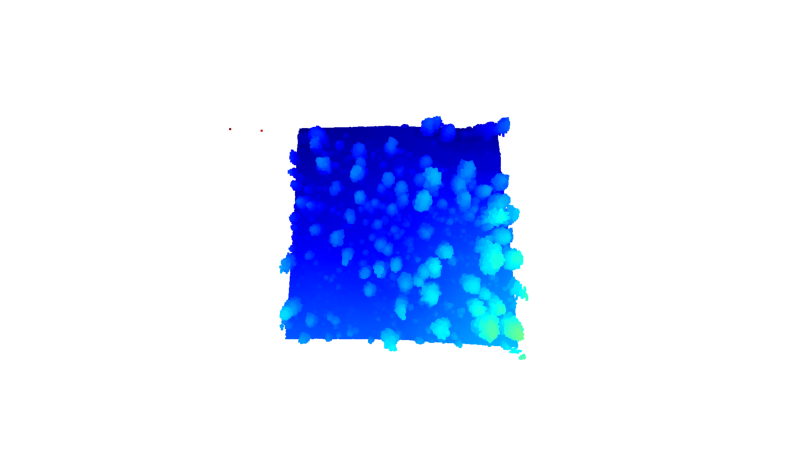

In [7]:
# Visualize original file with preset camera pos
# declare camera state matrices and apply them
extrinsic = [
        [ 8.91845328e-01, -3.93401864e-01,  2.23264158e-01, -1.86350146e+06],
        [ 7.94960049e-02, -3.49579457e-01, -9.33528033e-01,  1.80762530e+05],
        [ 4.45300231e-01,  8.50311224e-01, -2.80496929e-01, -2.07756524e+06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]
    ]
src_preset_file = "../data/split_testing/tiles/color_grp_full_tile_311.laz"
src_out_image = src_test_file.split('.laz')[0] + '_original.png'
visualize_laz(src_preset_file, mode='normal', display_mode='image', extrinsic=extrinsic, image_dest_src=None)

In [16]:
# Visualize semantic segmentation

src_out_image = src_test_file_segmented.split('_out.laz')[0] + '_semantic.png'
visualize_laz(src_test_file_segmented, mode='semantic', display_mode='3d', image_dest_src=None, gt=True)

KeyboardInterrupt: 

In [15]:
# Visualize instance segmentation
src_out_image = src_test_file_segmented.split('_out.laz')[0] + '_instance.png'
visualize_laz(src_test_file, mode='instance', display_mode='3d', image_dest_src=None, gt=True)

[1 1 1 ... 0 0 0]


### Different file format generation

#### Utils

In [2]:
def convert_laz_to_las(in_laz, out_las, verbose=True):
    las = laspy.read(in_laz)
    las = laspy.convert(las)
    las.write(out_las)
    if verbose:
        print(f"LAZ file saved in {out_las}")

def convert_las_to_laz(in_las, out_laz, verbose=True):
    """
    Convert a LAS file to a LAZ file, stripping all extra dimensions.

    Parameters:
    - in_las: str, path to the input .las file
    - out_laz: str, path to the output .laz file
    - verbose: bool, whether to print a success message

    Returns:
    - None
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": in_las
            },
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip",  # Ensure compression to LAZ
                # "extra_dims": "none"
            }
        ]
    }

    # Create and execute the pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()

    if verbose:
        print(f"LAZ file saved at {out_laz}")

def convert_pcd_to_laz(in_pcd, out_laz, verbose=True):
    # pcd = laspy.read('../data/testing_samples/split_0332.pcd')
    pipeline_json = {
        "pipeline": [
            in_pcd,  # Read the PCD file
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip"  # Ensures .laz compression
                ""
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:4326",
                "out_srs": "EPSG:2056"
            }
        ]
    }

    # Run the PDAL pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()
    
    if verbose:
        print(f"LAZ file saved in {out_laz}")

def convert_laz_to_pcd(in_laz, out_pcd, verbose=True):
    laz = laspy.read(in_laz)

    # Gathering all attributes from laz file
    points = np.vstack((laz.x, laz.y, laz.z)).T

    attributes = {}
    for attribute in laz.point_format.dimensions:
        if attribute.name in ['X', 'Y', 'Z']:
            continue
        attributes[attribute.name] = getattr(laz, attribute.name)
    
    # Preparing data for pcd
    num_points = points.shape[0]
    fields = ["x", "y", "z"] + list(attributes.keys())  # All field names
    types = ["F", "F", "F"] + ["F" for _ in attributes]  # Float32 fields
    sizes = [4] * len(fields)  # 4-byte float per field

    # Stack all data into a single NumPy array
    data = np.column_stack([points] + [attributes[key] for key in attributes])

    # Write to a PCD file
    with open(out_pcd, "w") as f:
        # f.write(f"# .PCD v0.7 - Point Cloud Data file format\n")
        f.write(f"VERSION 0.7\n")
        f.write(f"FIELDS {' '.join(fields)}\n")
        f.write(f"SIZE {' '.join(map(str, sizes))}\n")
        f.write(f"TYPE {' '.join(types)}\n")
        f.write(f"COUNT {' '.join(['1'] * len(fields))}\n")
        f.write(f"WIDTH {num_points}\n")
        f.write(f"HEIGHT 1\n")
        f.write(f"VIEWPOINT 0 0 0 1 0 0 0\n")
        f.write(f"POINTS {num_points}\n")
        f.write(f"DATA ascii\n")
    
        # Write data
        np.savetxt(f, data, fmt=" ".join(["%.6f"] * len(fields)))

    if verbose:
        print(f"PCD file saved in {out_pcd}")


# convert_pcd_to_laz(r"C:\temp_stockage_pdm\PDM_repos\Data_samples_cat\Single\color_grp_000020.pcd",r"C:\temp_stockage_pdm\PDM_repos\Data_samples_cat\Single\color_grp_000020.laz")

#### Transform laz to las and pcd

In [6]:
# From laz to las
for file_in in [src_test_file, src_test_file_segmented]:
    file_out = file_in.split('.laz')[0] + '.las'
    convert_laz_to_las(file_in, file_out)

LAS file saved in ../data/testing_samples/split_0332.las
LAS file saved in ../data/testing_samples/split_0332_out.las


In [ ]:
# From laz to pcd
for file_in in [src_test_file, src_test_file_segmented]:
    file_out = file_in.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(file_in, file_out)

PCD file saved in ../data/testing_samples/split_0332.pcd
PCD file saved in ../data/testing_samples/split_0332_out.pcd


### Convert all files of folder

#### from laz to pcd

In [ ]:
# src_folder = r"..\data\split_testing\gt\corrections\color_grp_full_tile_633_out_split_instance\missed"
src_folder = r"D:\PDM_repo\Data_full_pc\full_pc_flattened_barycentric\Flattened_PC\groups_las"
src_folder = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_2\gt\round1"
files = [x for x in os.listdir(src_folder) if x.endswith('.laz')]
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(os.path.join(src_folder, file), os.path.join(src_folder, file_out), verbose=False)

0it [00:00, ?it/s]


#### from pcd to laz

In [3]:
src_folder = r"..\data\split_testing\gt\final_gt\color_grp_full_tile_633_final\instances"
src_folder = r"D:\PDM_repo\Github\PDM\data\dataset_pipeline\tiles_20\loops - Copy\0\preds\color_grp_full_tile_124_out_split_instance\results\single"
list_files = os.listdir(src_folder)
for _, file in tqdm(enumerate([x for x in list_files if x.endswith('.pcd')]), total=len([x for x in list_files if x.endswith('.pcd')])):
    if file.endswith('.pcd'):
        src_in = os.path.join(src_folder, file)
        src_out = os.path.join(src_folder, file.split('.pcd')[0] + '.laz')
        convert_pcd_to_laz(src_in, src_out,verbose=False)

100%|██████████| 124/124 [00:05<00:00, 21.40it/s]


#### from las to laz

In [5]:
# src_folder = r"..\data\split_testing\gt\corrections\color_grp_full_tile_633_out_split_instance\missed"
src_folder = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_2\gt\round2"
files = [x for x in os.listdir(src_folder) if x.endswith('.las')]
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.las')[0] + '.laz'
    convert_las_to_laz(os.path.join(src_folder, file), os.path.join(src_folder, file_out), verbose=False)

100%|██████████| 10/10 [00:00<00:00, 72.00it/s]


### Semantic splitting

#### Utils

In [ ]:
def split_semantic(src, show_images=False, verbose=True):
    # Define target folder:
    dir_target = os.path.dirname(src) + '/' + src.split('/')[-1].split('.')[0] + "_split_semantic"

    if not os.path.exists(dir_target):
        os.makedirs(dir_target)

    points_segmented = laspy.read(src_test_file_segmented)
    val_to_name = ['ground', 'tree']

    for val, name in enumerate(val_to_name):
        file_name = src_test_file_segmented.split('\\')[-1].split('/')[-1].split('.laz')[0] + f'_{name}.laz'
        file_src = os.path.join(dir_target, file_name)

        # create new file
        # new_file = laspy.create(point_format=points_segmented.header.point_format, file_version=points_segmented.header.version)
        # new_file.points = points_segmented.points[points_segmented.PredSemantic == val]
        # new_file.write(file_src, do_compress=True)

        # Define the PDAL pipeline for filtering
        pipeline_json = {
            "pipeline": [
                src,
                {
                    "type": "filters.expression",
                    "expression": f"PredSemantic == {val}"
                },
                file_src
            ]
        }

        # Run PDAL pipeline
        pipeline = pdal.Pipeline(json.dumps(pipeline_json))
        pipeline.execute()
        
        # convert new file
        convert_laz_to_las(file_src, file_src.split('.laz')[0] + '.las', verbose=verbose)
        convert_laz_to_pcd(file_src, file_src.split('.laz')[0] + '.pcd', verbose=verbose)
        if show_images:
            visualize_laz(file_src, mode='normal', display_mode='image')
    if verbose:
        print("SEMANTIC SPLITTING DONE")


#### Splitting

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


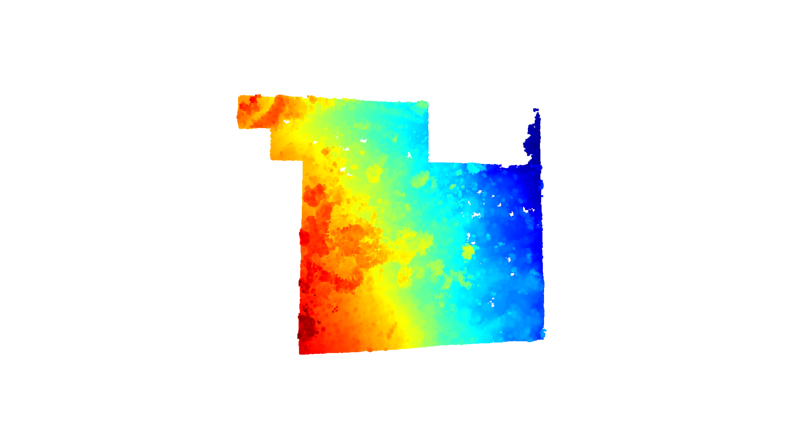

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


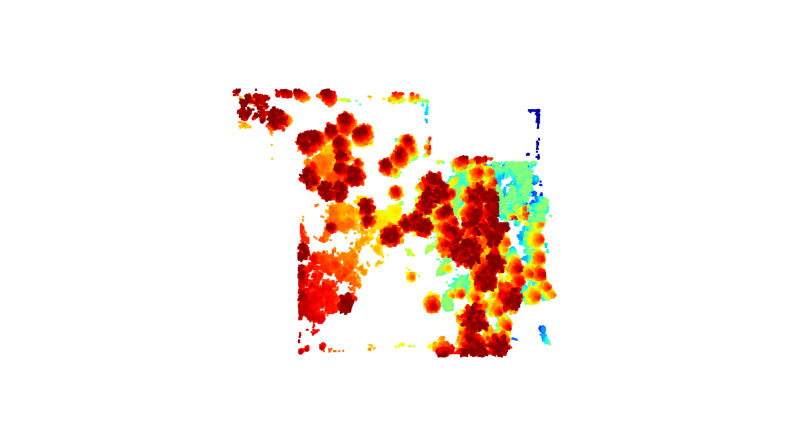

In [14]:
split_semantic(src_test_file_segmented, show_images=True, verbose=False)

### Instances splitting

#### Utils

In [9]:
def split_instance(src, show_images=False, instance_col_name='PredInstance', verbose=True):
    # Define target folder:
    dir_target = os.path.dirname(src) + '/' + src.split('/')[-1].split('.')[0] + "_split_instance"

    if not os.path.exists(dir_target):
        os.makedirs(dir_target)

    points_segmented = laspy.read(src)

    for idx, instance in tqdm(enumerate(set(points_segmented[instance_col_name])), total=len(set(points_segmented[instance_col_name]))):
        file_name = src.split('\\')[-1].split('/')[-1].split('.laz')[0] + f'_{instance}.laz'
        file_src = os.path.join(dir_target, file_name)

        # create new file
        # new_file = laspy.create(point_format=points_segmented.header.point_format, file_version=points_segmented.header.version)
        # new_file.points = points_segmented.points[points_segmented.PredInstance == instance]
        # # print(list(new_file.point_format.dimension_names))
        # # print(new_file.PredInstance)
        # # continue
        # new_file.write(file_src)

        # Define the PDAL pipeline for filtering
        pipeline_json = {
            "pipeline": [
                src,
                {
                    "type": "filters.expression",
                    "expression": f"{instance_col_name} == {instance}"
                },
                file_src
            ]
        }

        # Run PDAL pipeline
        pipeline = pdal.Pipeline(json.dumps(pipeline_json))
        pipeline.execute()

        # convert new file
        convert_laz_to_las(file_src, file_src.split('.laz')[0] + '.las', verbose=False)
        convert_laz_to_pcd(file_src, file_src.split('.laz')[0] + '.pcd', verbose=False)
        if show_images:
            visualize_laz(file_src, mode='normal', display_mode='image')

    if verbose:
        print(f"INSTANCE SPLITTING DONE on {src}")


#### Splitting

In [ ]:
src_file = "../data/split_testing/gt/color_grp_full_tile_633_out.laz"
src_file = r"..\data\dataset_tiles_100m\tiles_one\preds\color_grp_full_tile_1_out.laz"
split_instance(src_file, show_images=False, verbose=True)

NameError: name 'split_instance' is not defined

#### Splitting all files of one folder

In [11]:
src_folder = "../data/classification_gt"
files = [x for x in os.listdir(src_folder) if x.endswith('.laz')]
for file in files:
    split_instance(os.path.join(src_folder, file), instance_col_name='gt_instance_segmentation', show_images=False)

100%|██████████| 149/149 [00:26<00:00,  5.65it/s]

INSTANCE SPLITTING DONE on ../data/classification_gt\color_grp_full_tile_633_out_gt.laz


### RANDOM STUFF

In [22]:
src_test_file = r"D:\PDM_repo\Github\PDM\data\temp\group_3000010.las"
src_test_file = r"D:\PDM_repo\Github\PDM\data\temp\group_3008954.las"
src_test_file = r"D:\PDM_repo\Github\PDM\data\temp\group_3009484.las"
src_test_file = r"D:\PDM_repo\Github\PDM\data\temp\group_3012715.las"
# src_test_file = r"D:\PDM_repo\Github\PDM\data\temp\group_11002366.laz"
points = laspy.read(src_test_file)
# points_segmented = laspy.read(src_test_file_segmented)

# List available attributes
print("Available point attributes in original file:")
for x in list(points.point_format.dimension_names):
    print(x)
print('---')
print("Extra dimension names:")
for ed in points.point_format.extra_dimension_names:
    print(ed)
print('---')
print("set of values of 'classification': ", set(points.classification))
print("set of values of 'point_source_id': ", set(points.point_source_id))
print("First element of ExtraBytes: ", points['ExtraBytes'][0])
# print("Available point attributes in segmented file:")
# print(list(points_segmented.point_format.dimension_names))



Available point attributes in original file:
X
Y
Z
intensity
return_number
number_of_returns
synthetic
key_point
withheld
overlap
scanner_channel
scan_direction_flag
edge_of_flight_line
classification
user_data
scan_angle
point_source_id
gps_time
red
green
blue
Amplitude
Pulse width
Reflectance
ExtraBytes
---
Extra dimension names:
Amplitude
Pulse width
Reflectance
ExtraBytes
---
set of values of 'classification':  {4}
set of values of 'point_source_id':  {0}
First element of ExtraBytes:  [ 71   0   0   0 107 248  45   0  66 165 150 249]


In [25]:
print(set(points_segmented.PredSemantic))
for val in set(points_segmented.PredSemantic):
    print(f"Number of point of class {val}: {len([x for x in points_segmented.PredSemantic if x == val])}")

{0, 1}
Number of point of class 0: 305864
Number of point of class 1: 200852


In [33]:
visualize_laz(src_test_file_segmented, True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


#### finding the average number of points / m^2

In [3]:
full_data = laspy.read(r"D:\PDM_repo\Data_full_pc\full_pc_color_grp\color_grp_full.laz")

In [8]:
x_min = full_data.x.min()
x_max = full_data.x.max()
y_min = full_data.y.min()
y_max = full_data.y.max()
x_length = x_max - x_min
y_length = y_max - y_min
surf = x_length * y_length
num_points = len(full_data)
density = num_points / surf
print("X span [m]: ", x_length)
print("Y span [m]: ", y_length)
print("Surface: [m^2]", surf)
print("Number of points [-]: ", num_points)
print("Density of points [m^-2]: ", round(density, 2))

X span [m]:  3713.470000000205
Y span [m]:  2753.2600000000093
Surface: [m^2] 10224148.412200598
Number of points [-]:  272168582
Density of points [m^-2]:  26.62
